# Installation
Import the libs used in this notebook

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras import applications as apps
from tensorflow.keras import layers, optimizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint

# Dataset and metrics visualization

APIs:
* plot_dataset(ds, count, title): The default value of count is 4. The default value of title is 'dataset'.
* plot_acc(history): The history object is returned by the training function.
* plot_loss(history): The history object is returned by the training function.


## Dataset

In [3]:
def title_color(label):
  color = 'black'

  if isinstance(label, np.ndarray):
    color = 'green' if label[0] == label[1] else 'red'

  return color

def plot_dataset(ds, count=4, title='dataset'):
  size = 4
  cols = 4
  rows = int((count+cols-1) / cols)

  ds_itr = ds.as_numpy_iterator()
  fig = plt.figure(figsize=(size*cols, size*rows))
  items = map(lambda id: (id,) + ds_itr.next(), range(count))

  for id, image, label in items:
    colid = id % cols
    rowid = id / cols

    ax = fig.add_subplot(rows, cols, id+1)

    ax.set_title(label, color=title_color(label))
    ax.imshow(image)
    ax.axis("off")
  
  fig.suptitle(title)
  plt.show()

## Metrics

In [4]:
def plot_acc(history):
  val = history.history.get('val_accuracy')
  legend = ['train', 'val'] if val else ['train']

  plt.plot(history.history['accuracy'])
  if val: plt.plot(history.history['val_accuracy'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

def plot_loss(history, val=False):
  val = history.history.get('val_loss')
  legend = ['train', 'val'] if val else ['train']

  plt.plot(history.history['loss'])
  if val: plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.show()

# Dataset creation

We use the *oxford_flowers102* to demonstrate the sample efficiency improvements. The dataset has integer class labels for the flower images. To identify the flowers by name, use the following links:
 * [Name=>Label](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1)
 * [Label=>Visual](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html) 

In this section, we create a **tf.data.Dataset** tensorflow object. We also create a small sample dataset for testing purposes. The dataset elements are formatted as a tuple *(image, class_label)*. We expose the following objects:
* train_prep_ds (Training dataset)
* val_prep_ds (Validation dataset)

In [5]:
%%capture
(train_ds, val_ds), ds_info = tfds.load(
    'oxford_flowers102',
    with_info=True,
    split=['train', 'validation'],
    as_supervised=False,
    read_config=tfds.ReadConfig(try_autocache=False)
)

In [6]:
# Dataset image size
IMG_SIZE = 264

def dsitem_to_tuple(item):
  return (item['image'], item['label'])

def resize_image(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.cast(image, tf.uint8)
  return image, label

In [7]:
train_ds = train_ds.map(dsitem_to_tuple).map(resize_image).cache()
val_ds = val_ds.map(dsitem_to_tuple).map(resize_image).cache()

In [8]:
print(train_ds.as_numpy_iterator().next()[0].shape)
print(val_ds.as_numpy_iterator().next()[0].shape)

(264, 264, 3)
(264, 264, 3)


# Model architecture

We use a ResNet50 model pre-trained on the ImageNet dataset. The oxford_flowers102 is a small dataset with 1020 training images and 1020 validation images. Such a small sample is insufficient to train a model from scratch. However, with the pre-trained weights, this dataset is more than enough to achieve decent predictions. The model is exposed through a **model** variable. 

In [9]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.0002
NUM_CLASSES = 102

def create_model():
  # Initalize the core model
  core_args = dict(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
  core = apps.resnet50.ResNet50(**core_args)
  core.trainable = False

  # Setup the top
  model = tf.keras.Sequential([
    layers.Input([IMG_SIZE, IMG_SIZE, 3], dtype = tf.uint8),
    layers.Lambda(lambda x: tf.cast(x, tf.float32)),
    layers.Lambda(lambda x: apps.resnet.preprocess_input(x)),
    core,
    layers.Flatten(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  adam = optimizers.Adam(learning_rate=LEARNING_RATE)

  model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 264, 264, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 264, 264, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 9, 9, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dropout (Dropout)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 102)               16920678  
                                                         

# Training Setup

In [10]:
def train(model, tds, vds, batch_size=24, epochs=100):
  tds = tds.shuffle(1000, reshuffle_each_iteration=True)
  batch_tds = tds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  batch_vds = vds.batch(256).prefetch(tf.data.AUTOTUNE)

  # Save the best weights during training
  tmpl = 'weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
  checkpoints = ModelCheckpoint(tmpl, save_best_only=True, monitor="val_accuracy")

  history = model.fit(
    batch_tds,
    validation_data=batch_vds,
    epochs=epochs,
    callbacks=[checkpoints]
  )

  return history

# Experiments

## baseline

Epoch 1/100
43/43 [==============================] - 39s 536ms/step - loss: 4.6282 - accuracy: 0.3980 - val_loss: 1.8141 - val_accuracy: 0.6814
Epoch 2/100
43/43 [==============================] - 10s 232ms/step - loss: 0.0571 - accuracy: 0.9804 - val_loss: 2.0710 - val_accuracy: 0.6863
Epoch 3/100
43/43 [==============================] - 9s 214ms/step - loss: 9.6717e-05 - accuracy: 1.0000 - val_loss: 1.9961 - val_accuracy: 0.6853
Epoch 4/100
43/43 [==============================] - 10s 236ms/step - loss: 3.0470e-05 - accuracy: 1.0000 - val_loss: 1.9878 - val_accuracy: 0.6882
Epoch 5/100
43/43 [==============================] - 10s 238ms/step - loss: 1.1971e-05 - accuracy: 1.0000 - val_loss: 1.9838 - val_accuracy: 0.6892
Epoch 6/100
43/43 [==============================] - 9s 220ms/step - loss: 1.0515e-05 - accuracy: 1.0000 - val_loss: 1.9794 - val_accuracy: 0.6892
Epoch 7/100
43/43 [==============================] - 10s 240ms/step - loss: 5.9275e-06 - accuracy: 1.0000 - val_loss: 1.97

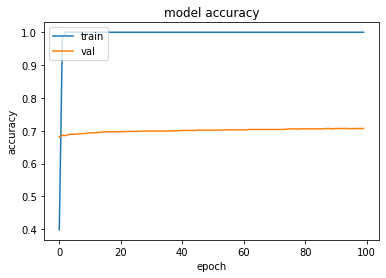

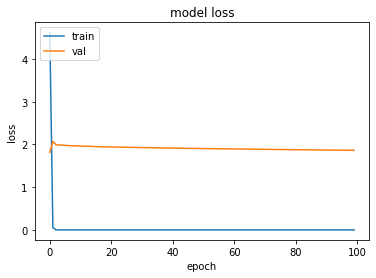

In [11]:
baseline_hist = train(model, train_ds, val_ds, batch_size=24, epochs=100)

plot_acc(baseline_hist)
plot_loss(baseline_hist)

## basicaug-hflip-rotate-0.1

In [12]:
augs = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
])

def augfn(image, label):
  image = tf.expand_dims(image, 0) # Introduce a batch dimension
  image = augs(image, training=True) # Apply augmentation
  image = tf.squeeze(image, axis=0) # Squeeze the batch
  return image, label

train_aug_ds = train_ds.map(augfn)

Epoch 1/100
43/43 [==============================] - 20s 260ms/step - loss: 7.1851 - accuracy: 0.5853 - val_loss: 13.1245 - val_accuracy: 0.4696
Epoch 2/100
43/43 [==============================] - 18s 257ms/step - loss: 3.9289 - accuracy: 0.7902 - val_loss: 8.5414 - val_accuracy: 0.6343
Epoch 3/100
43/43 [==============================] - 18s 259ms/step - loss: 1.8109 - accuracy: 0.8941 - val_loss: 6.6577 - val_accuracy: 0.6941
Epoch 4/100
43/43 [==============================] - 18s 258ms/step - loss: 0.5623 - accuracy: 0.9480 - val_loss: 6.8024 - val_accuracy: 0.6971
Epoch 5/100
43/43 [==============================] - 18s 257ms/step - loss: 0.2988 - accuracy: 0.9696 - val_loss: 4.9204 - val_accuracy: 0.7480
Epoch 6/100
43/43 [==============================] - 18s 237ms/step - loss: 0.4698 - accuracy: 0.9608 - val_loss: 5.0624 - val_accuracy: 0.7451
Epoch 7/100
43/43 [==============================] - 19s 255ms/step - loss: 0.2046 - accuracy: 0.9814 - val_loss: 4.8670 - val_accuracy

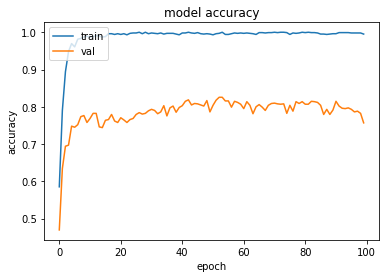

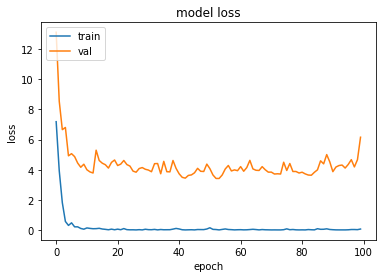

In [13]:
augs_hist = train(model, train_aug_ds, val_ds, batch_size=24, epochs=100)

plot_acc(augs_hist)
plot_loss(augs_hist)

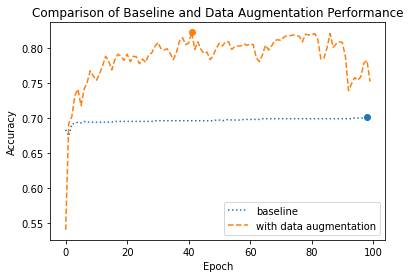

In [14]:
def plot(data, ax=None, style=None, label=None, linestyle=None, mark='max'):
    def mark_fn():
        markx = np.argmax(data) if mark == 'max' else np.argmin(data)
        marky = max(data) if mark == 'max' else min(data)
        ax.scatter(markx, marky, zorder=2)


    ax = ax or plt.gca()
    style = style or '-'
    label = label or ''
    ax.plot(data, label=label, linestyle=linestyle) if linestyle else ax.plot(data, style, label=label)

    mark_fn() if mark else None

baseline = [0.683300,0.674500,0.691200,0.692200,0.694100,0.693100,0.695100,0.694100,0.694100,0.694100,0.694100,0.694100,0.694100,0.694100,0.694100,0.694100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.695100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.696100,0.697100,0.697100,0.696100,0.697100,0.698000,0.697100,0.697100,0.697100,0.697100,0.698000,0.698000,0.698000,0.698000,0.698000,0.698000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.699000,0.700000,0.700000,0.700000,0.700000,0.701000,0.701000,]
augmented = [0.540200,0.692200,0.702000,0.732400,0.741200,0.717600,0.741200,0.751000,0.767600,0.759800,0.753900,0.762700,0.774500,0.788200,0.781400,0.768600,0.783300,0.791200,0.788200,0.782400,0.791200,0.780400,0.788200,0.787300,0.777500,0.784300,0.779400,0.790200,0.793100,0.802000,0.807800,0.799000,0.797100,0.799000,0.792200,0.783300,0.793100,0.809800,0.814700,0.804900,0.806900,0.822500,0.798000,0.808800,0.798000,0.792200,0.794100,0.783300,0.789200,0.800000,0.806900,0.802900,0.808800,0.808800,0.798000,0.802000,0.802900,0.802900,0.805900,0.803900,0.805900,0.804900,0.786300,0.780400,0.790200,0.803900,0.797100,0.802900,0.810800,0.811800,0.810800,0.815700,0.817600,0.817600,0.818600,0.817600,0.816700,0.808800,0.819600,0.818600,0.818600,0.820600,0.812700,0.784300,0.785300,0.800000,0.820600,0.801000,0.805900,0.808800,0.807800,0.787300,0.739200,0.749000,0.757800,0.753900,0.758800,0.778400,0.782400,0.752000,]

plot(baseline, label='baseline', linestyle='dotted')
plot(augmented, label='with data augmentation', style='--')

axes = plt.gca()
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy')
axes.set_title('Comparison of Baseline and Data Augmentation Performance')


axes.legend()
plt.show()